In [1]:
cd /tf/astromer

/tf/astromer


In [3]:
import tensorflow as tf
import json
import os

from core.data  import pretraining_records
from core.astromer import get_ASTROMER, train

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
exp_path = './runs/rnd_50'

In [5]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 200,
 'msk_frac': 0.5,
 'rnd_frac': 0.2,
 'same_frac': 0.2,
 'data': './data/records/white',
 'p': './runs/rnd_50',
 'batch_size': 5000,
 'epochs': 10000,
 'patience': 1000,
 'repeat': 5,
 'layers': 2,
 'heads': 4,
 'head_dim': 256,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001,
 'exp_date': '2021-07-15 21:06:10'}

In [6]:
test_batches = pretraining_records(os.path.join('./data/records/white', 'test'), 
                            conf['batch_size'], 
                            max_obs=conf['max_obs'],
                            repeat=1,
                            msk_frac=conf['msk_frac'],
                            rnd_frac=conf['rnd_frac'],
                            same_frac=conf['same_frac'])

sum([1 for x in test_batches.unbatch()])

12500

In [7]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

In [8]:
# tf.keras.utils.plot_model(astromer, show_shapes=True)

In [9]:
weights_path = '{}/weights'.format(conf['p'])
astromer.load_weights(weights_path)

In [10]:
from core.astromer import predict

In [12]:
result = predict(astromer, test_batches, conf)

prediction: 3it [00:56, 18.90s/it]


In [23]:
import numpy as np
from sklearn.metrics import r2_score

In [21]:
r2_masked = []
for yt, yp, m in zip(result['x_true'], result['x_pred'], result['mask']):
    
    y_true_mask = tf.boolean_mask(yt, m)
    y_pred_mask = tf.boolean_mask(yp, m)

    r2_value = r2_score(y_true_mask, y_pred_mask)
    r2_masked.append(r2_value)

In [24]:
print('r2: {}\nmse: {}'.format(np.mean(r2_masked), result['mse']))

r2: 0.9025290417444415
mse: 9.421298027038574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


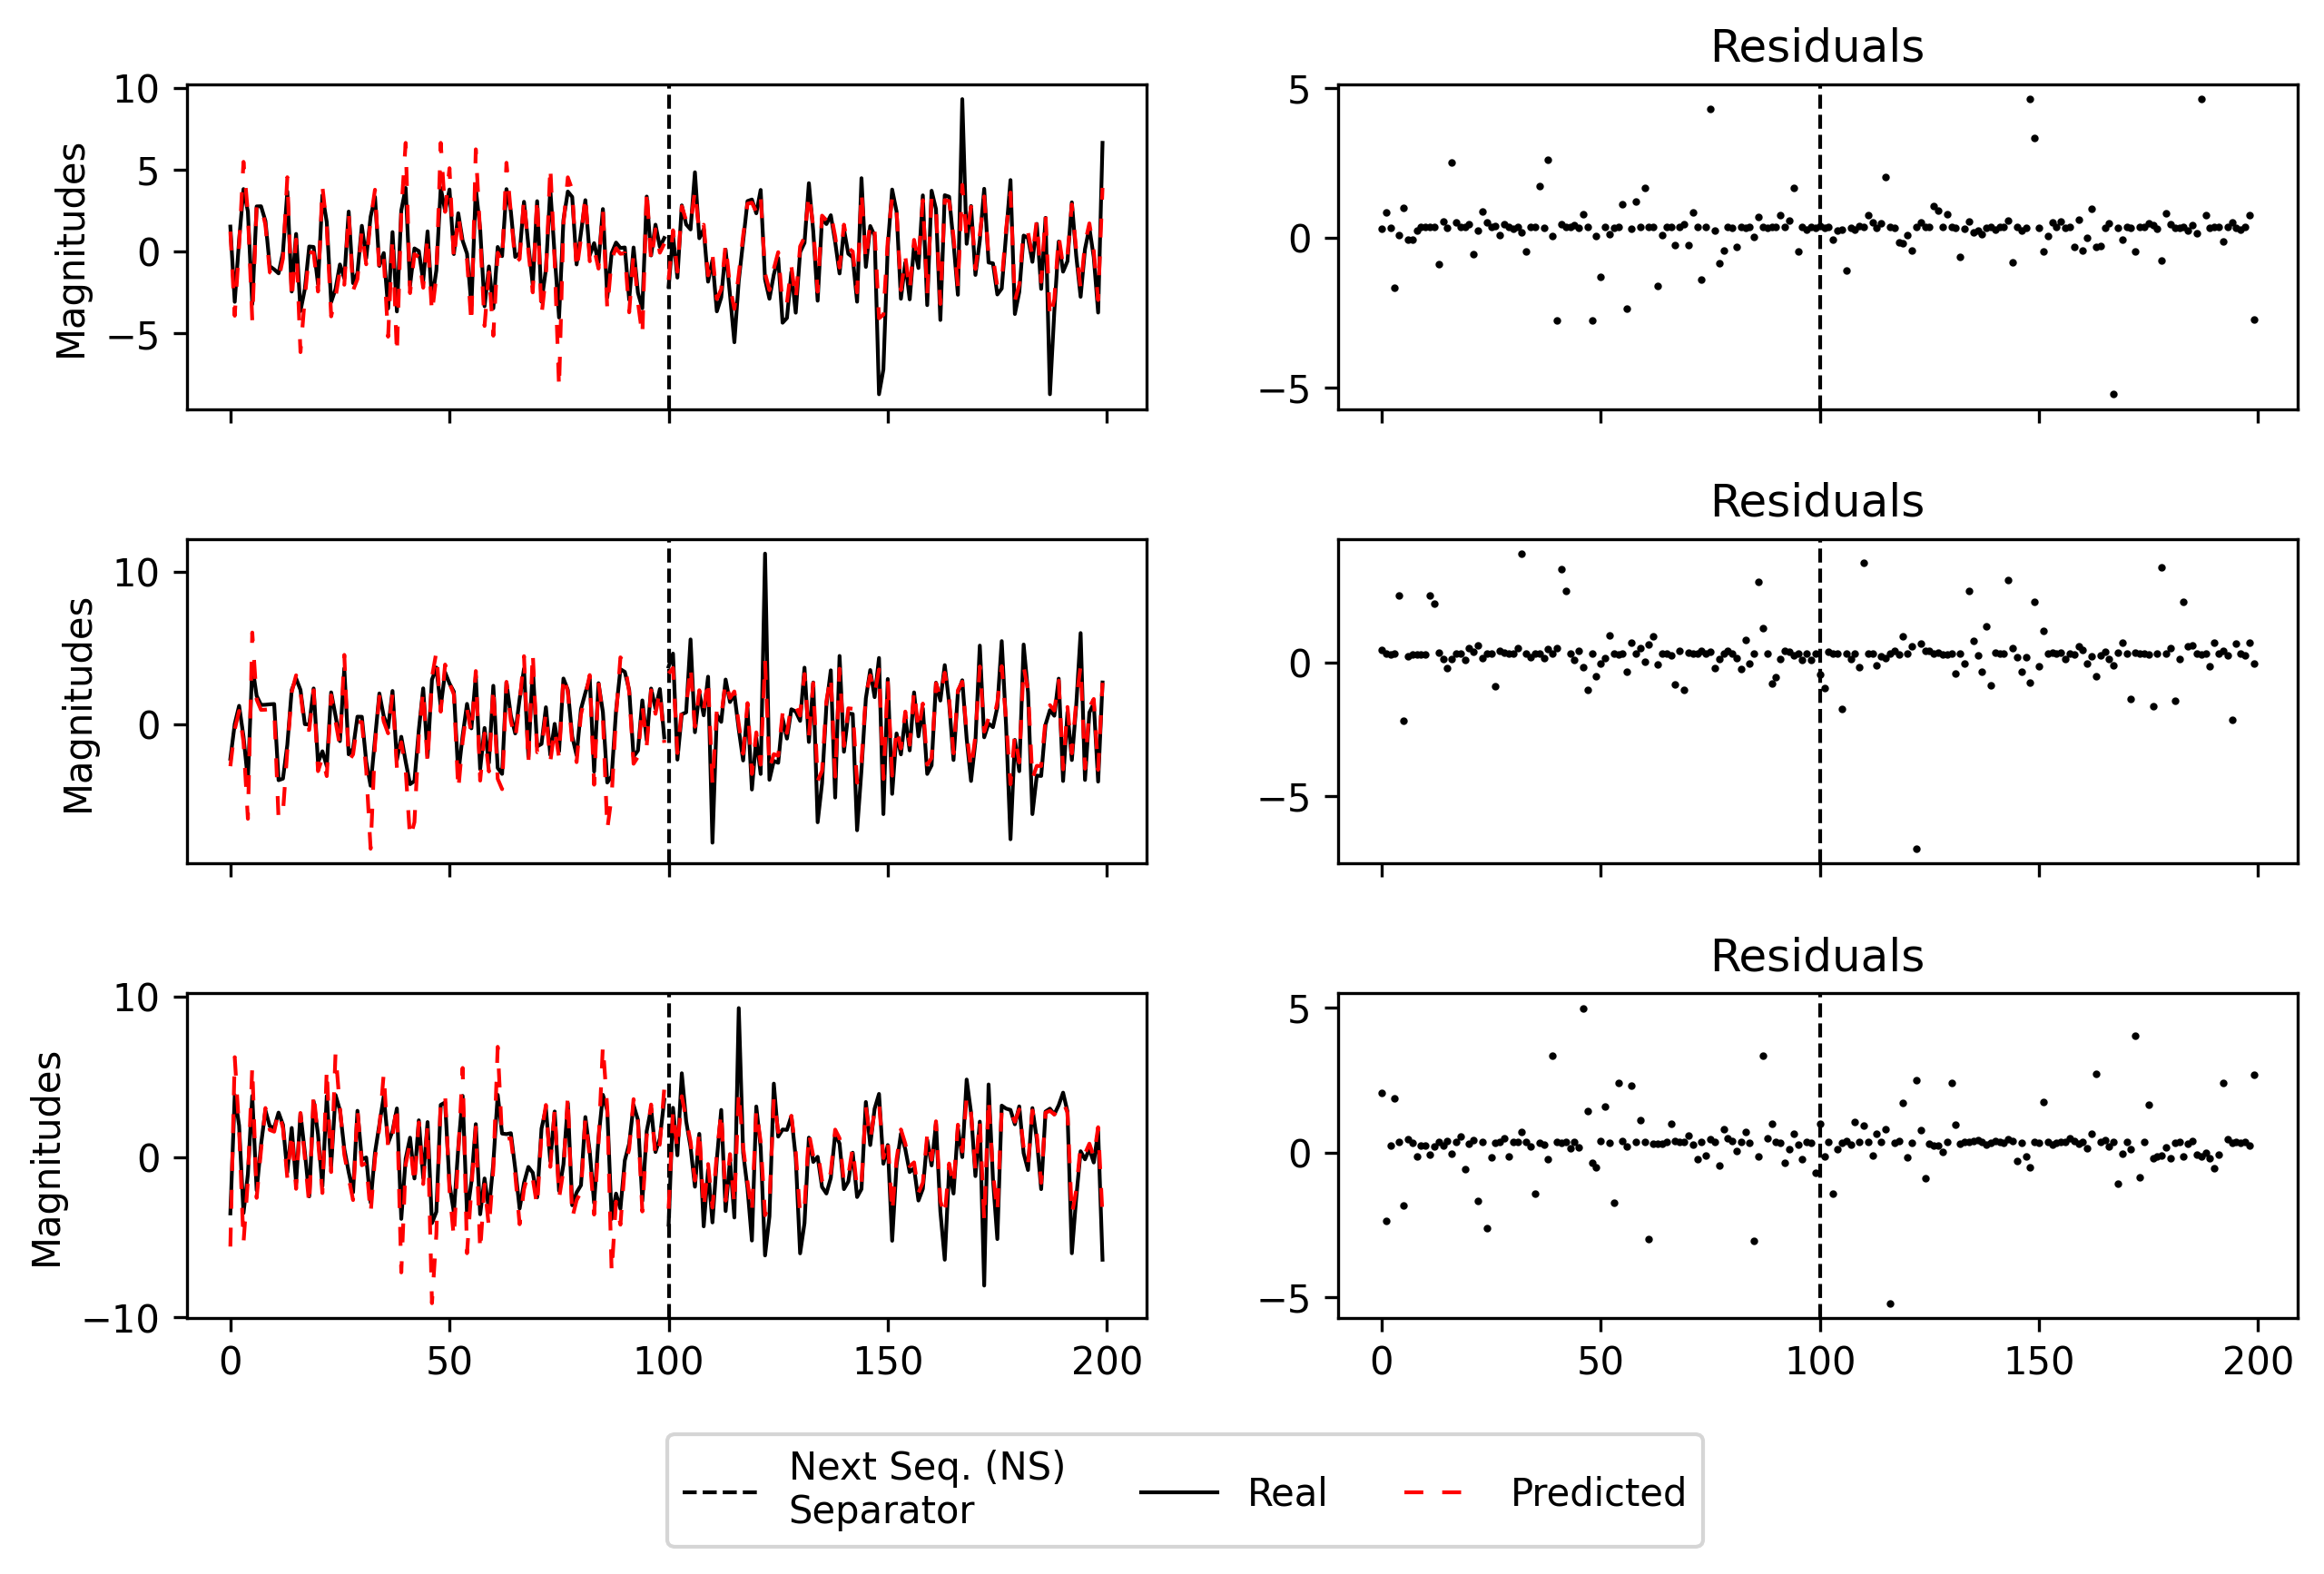

In [18]:
N = 3
fig, axes = plt.subplots(N, 2, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, conf['max_obs'])

    serie_1_pred = result['x_pred'][i][:obs, 0]
    serie_1_true = result['x_true'][i][:obs, 0]

    residual_1 = serie_1_pred - serie_1_true

    serie_2_pred = result['x_pred'][i][obs:, 0]
    serie_2_true = result['x_true'][i][obs:, 0]
    
    residual_2 = serie_2_pred - serie_2_true
    
    axes[i][0].axvline(x=obs, color='k', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='k')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))
    
    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2, color='k')
    axes[i][1].plot(times_post, residual_2, '.', markersize=2, color='k')
    axes[i][1].axvline(x=obs, color='k', linewidth=1, linestyle='--')
    axes[i][1].set_title('Residuals')
    
    

#     axes[i][0].set_title(r"NS Pred: "+npp_lab_pred+" | "+r"NS Real: "+npp_lab_true)

    axes[i][0].set_ylabel('Magnitudes')
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (1.6, -0.3))
fig.tight_layout()

## Learning Curves

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [20]:
pathexp = conf['p']
train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

Text(0.52, 0.0, 'Number of Epochs')

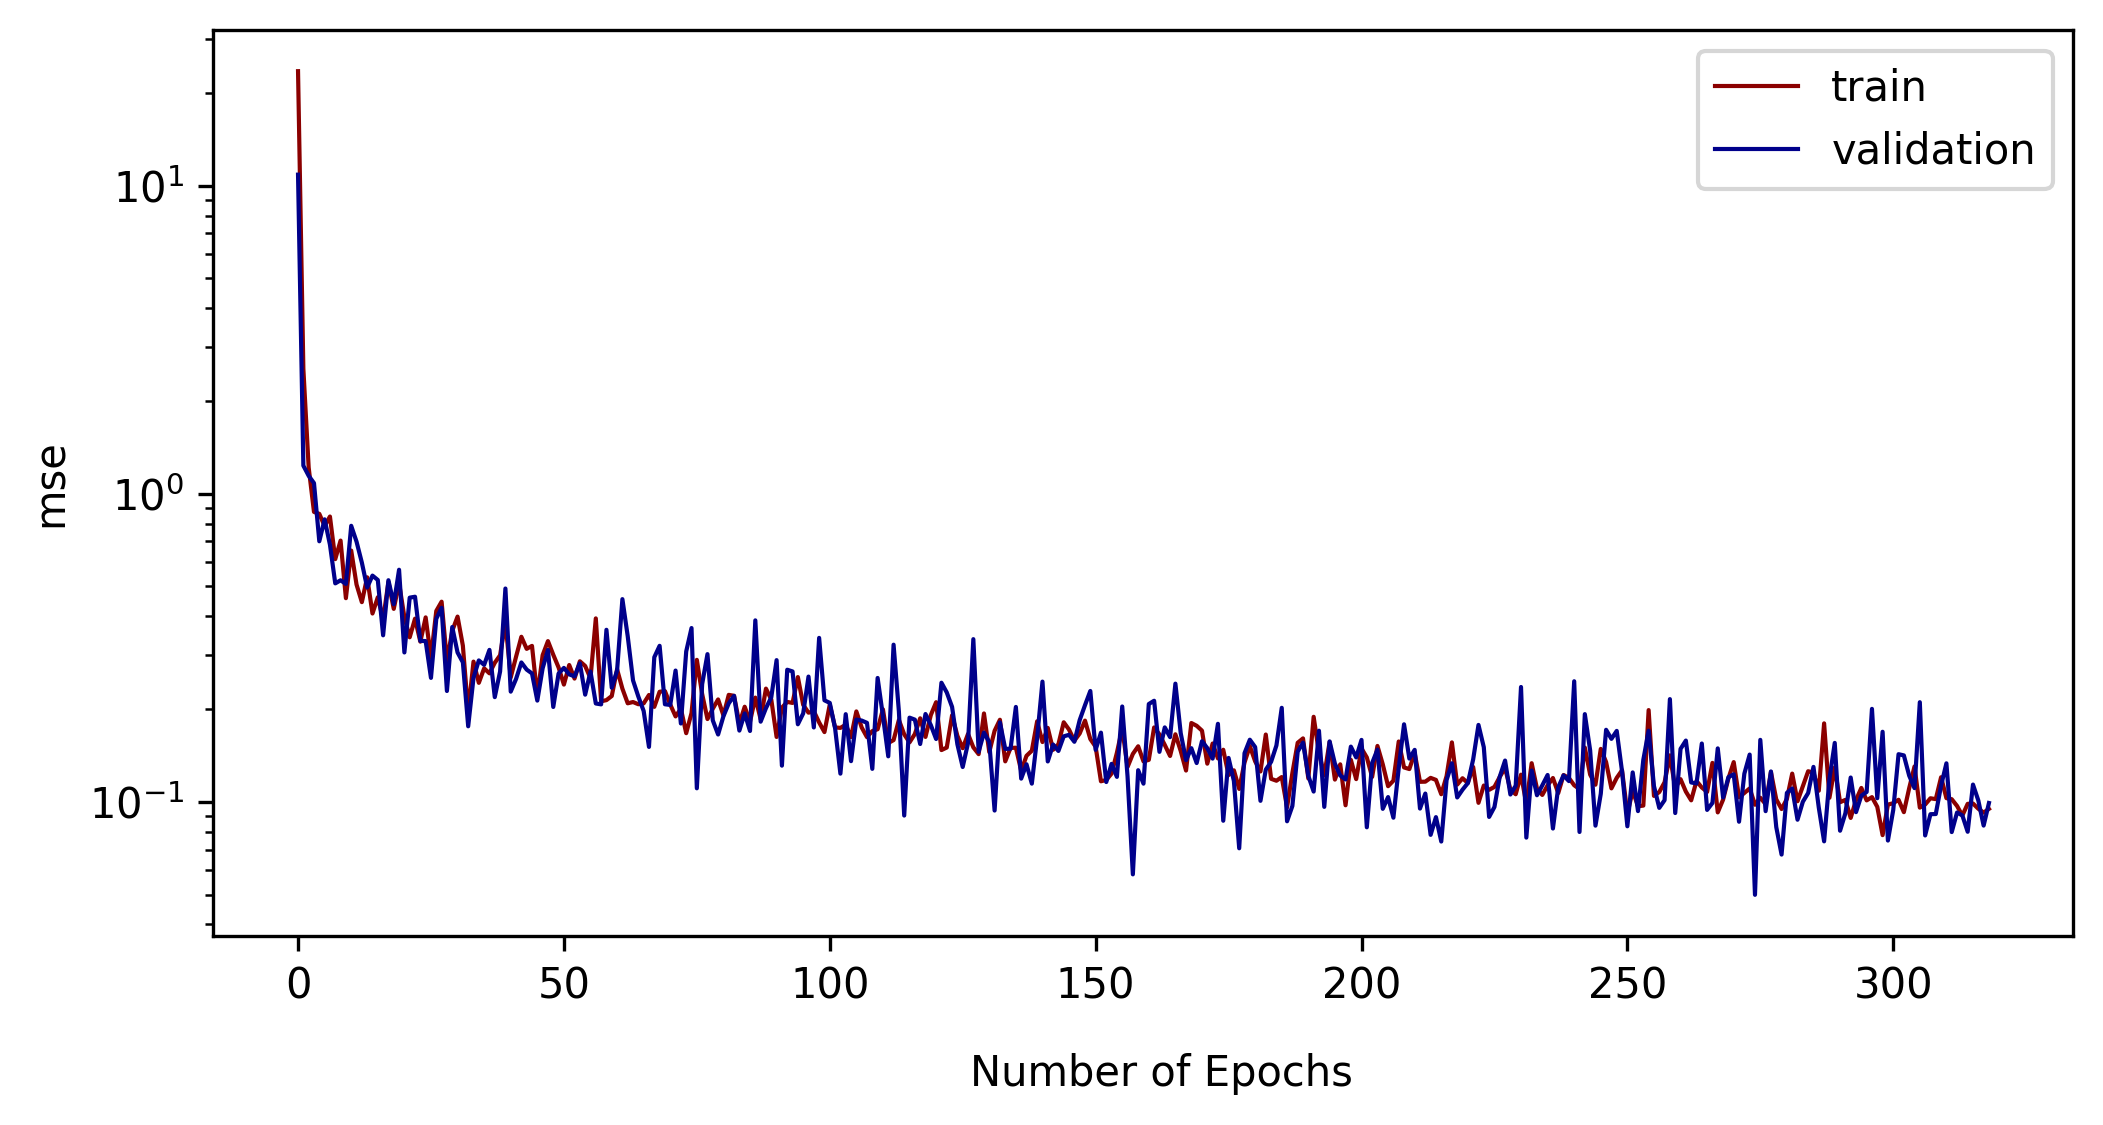

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(8,4), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(train_metrics.keys()):
    if key != 'mse':continue
    train_values = np.array(train_metrics[key])

    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes.plot(train_values, label='train', color='darkred', linewidth=1)
    axes.plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes.set_ylabel(key)
    if key != 'accuracy':
        axes.set_yscale('log')
axes.legend(loc='upper right')
fig.text(0.52, 0., 'Number of Epochs', ha='center')

## Finetuning

In [70]:
conf_file = os.path.join(conf['p'], 'finetuning', 'model','conf.json')
with open(conf_file, 'r') as handle:
    conf_ft = json.load(handle)
conf_ft

{'max_obs': 200,
 'data': './data/records/macho',
 'p': './runs/40MASKED/finetuning/model',
 'batch_size': 5000,
 'epochs': 10000,
 'patience': 1500,
 'repeat': 3,
 'layers': 2,
 'heads': 4,
 'head_dim': 128,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 1e-05,
 'msk_frac': 0.4,
 'rnd_frac': 0.15,
 'same_frac': 0.15,
 'exp_date': '2021-06-24 15:35:12'}

In [71]:
test_batches_ft = pretraining_records(os.path.join('./data/records/macho', 'test'), 
                            conf_ft['batch_size'], 
                            max_obs=conf_ft['max_obs'])

sum([1 for x in test_batches_ft.unbatch()])

527

In [72]:
ft_model = get_ASTROMER(num_layers=conf_ft['layers'],
                        d_model=conf_ft['head_dim'],
                        num_heads=conf_ft['heads'],
                        dff=conf_ft['dff'],
                        base=conf_ft['base'],
                        dropout=conf_ft['dropout'],
                        maxlen=conf_ft['max_obs'])

In [73]:
weights_path = '{}/weights'.format(conf_ft['p'])
ft_model.load_weights(weights_path)

In [74]:
result = predict(ft_model, test_batches_ft, conf_ft)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['lcid', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 1it [00:01,  1.53s/it]


In [75]:
print('r2: {}\nmse: {}'.format(r2_score(result['x_true'][...,0], result['x_pred'][...,0]), result['mse']))

r2: 0.9993589818146653
mse: 0.011015128344297409


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


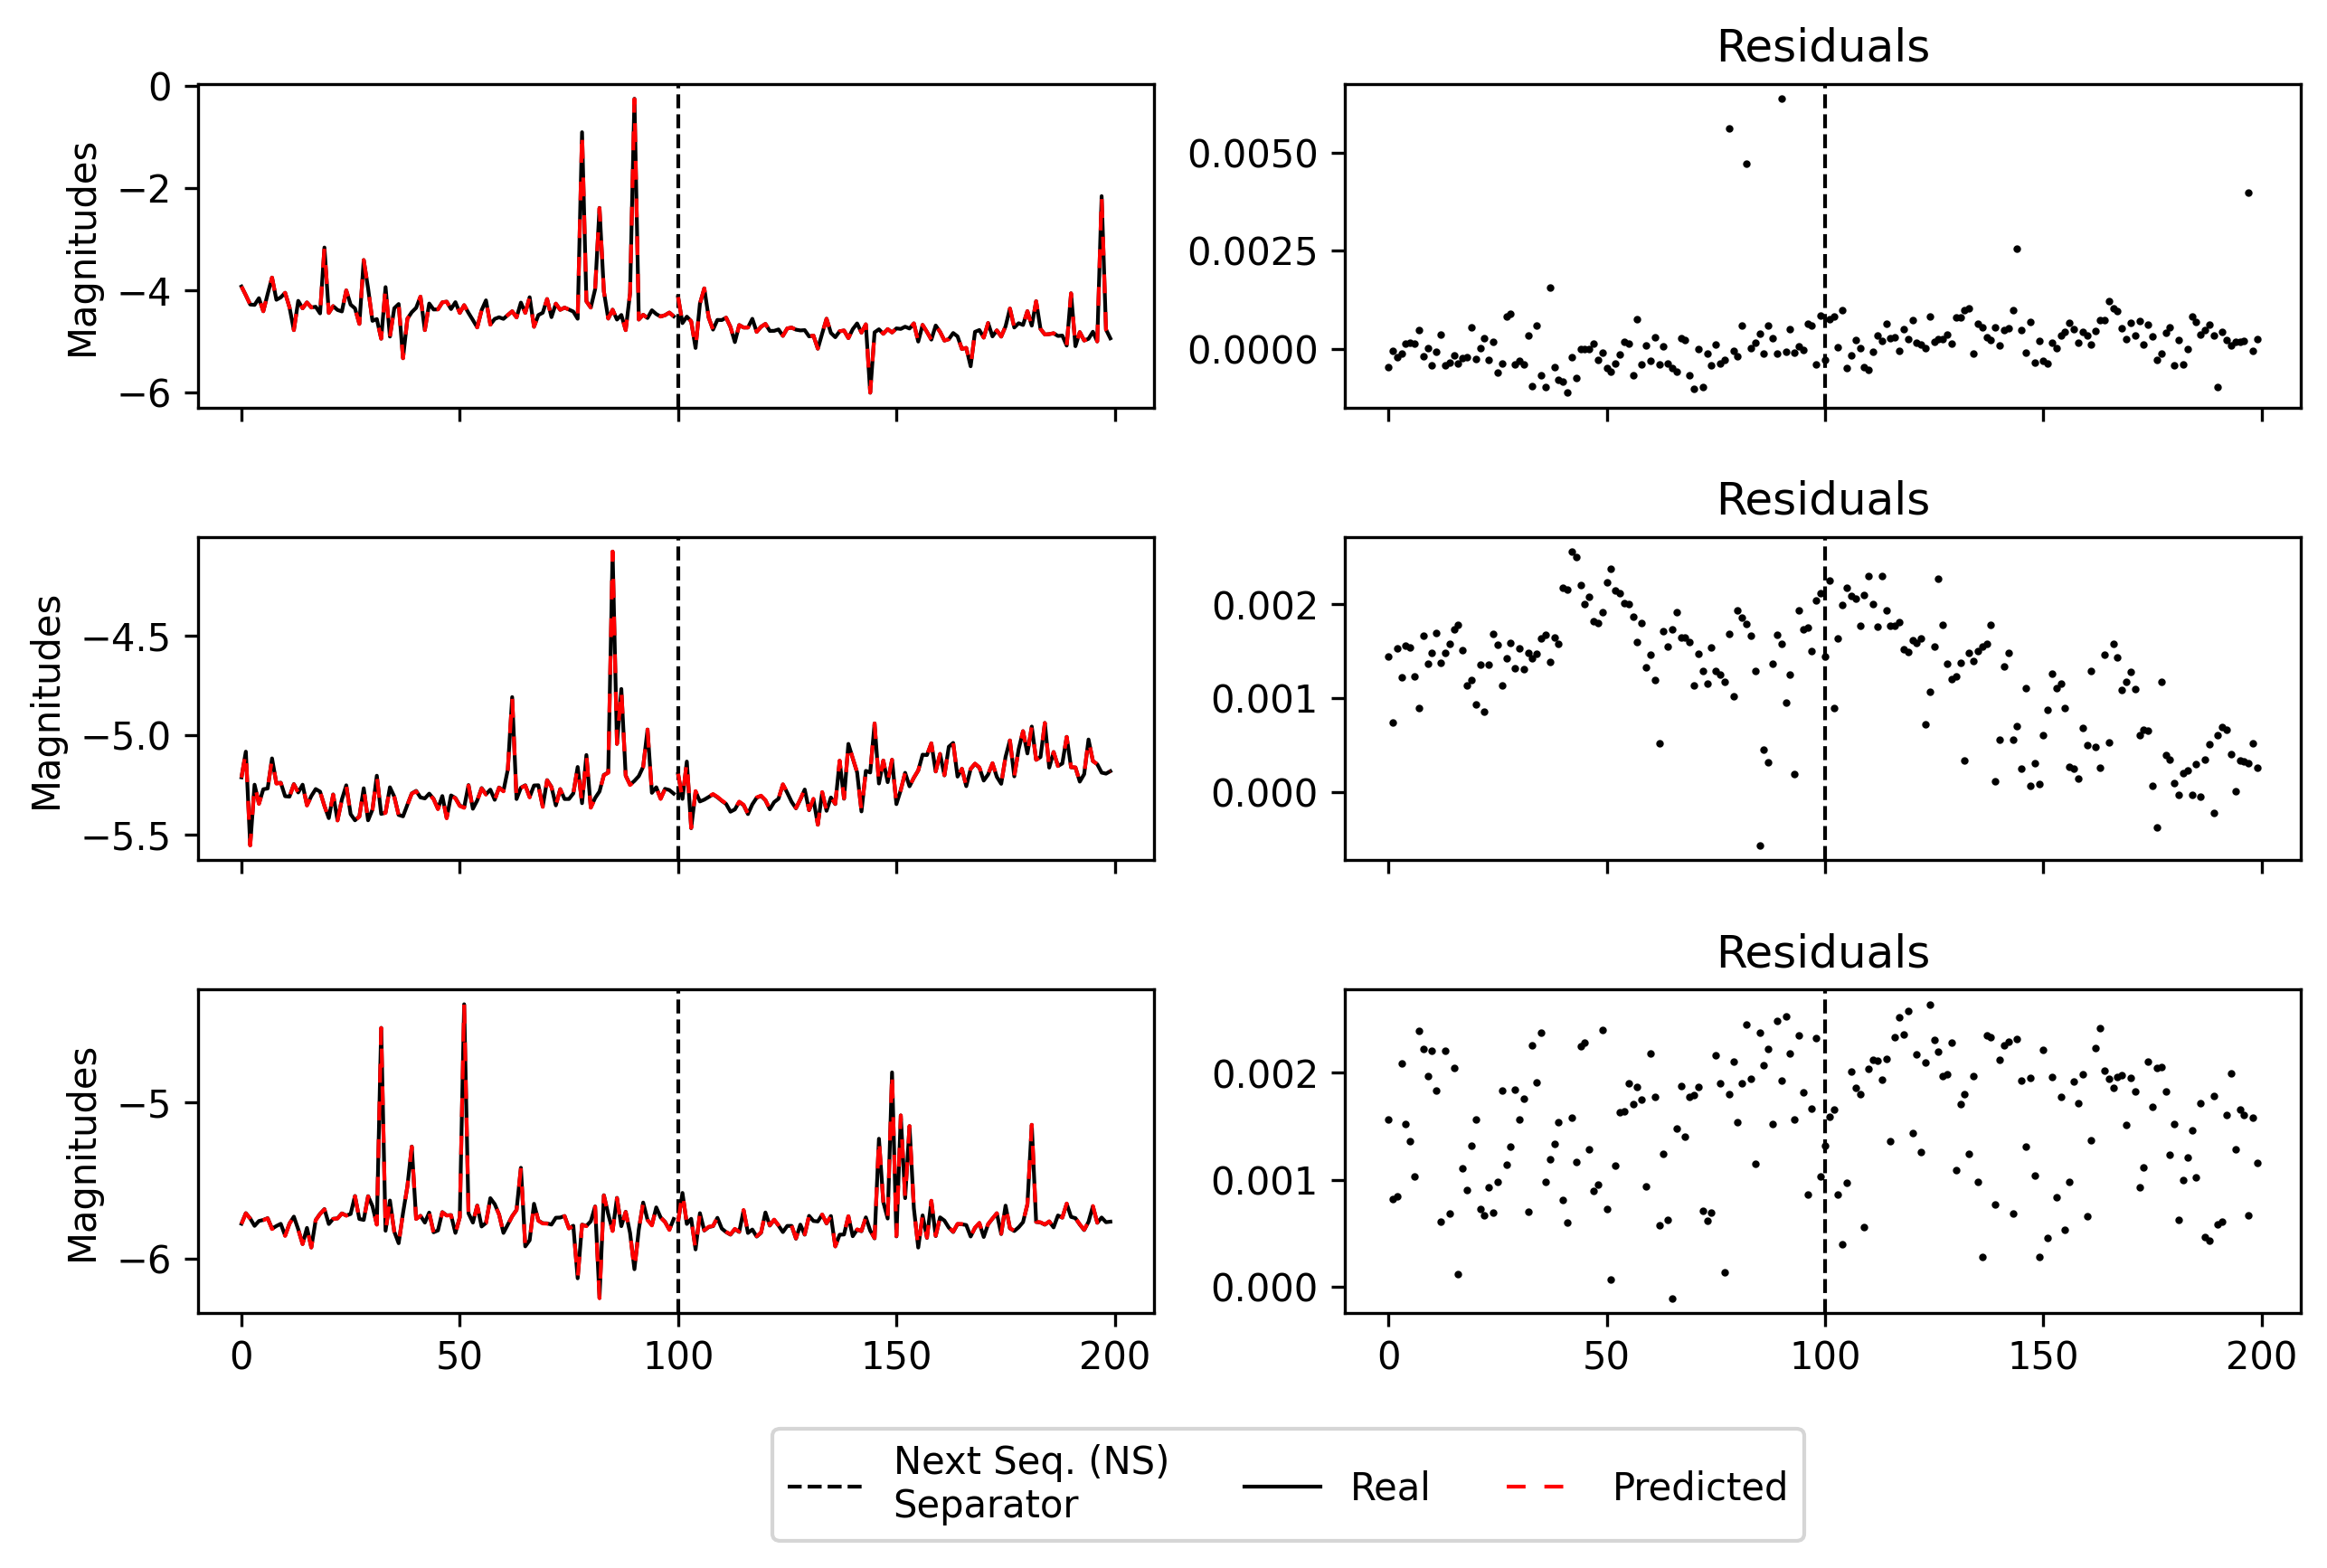

In [76]:
N = 3
fig, axes = plt.subplots(N, 2, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, conf['max_obs'])
    

    serie_1_pred = result['x_true'][i][:obs]
    serie_1_true = result['x_pred'][i][:obs]

    residual_1 = serie_1_pred - serie_1_true

    serie_2_pred = result['x_true'][i][obs:]
    serie_2_true = result['x_pred'][i][obs:]

    residual_2 = serie_2_pred - serie_2_true
    
    axes[i][0].axvline(x=obs, color='k', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='k')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))
    
    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2, color='k')
    axes[i][1].plot(times_post, residual_2, '.', markersize=2, color='k')
    axes[i][1].axvline(x=obs, color='k', linewidth=1, linestyle='--')
    axes[i][1].set_title('Residuals')
    
    

    axes[i][0].set_ylabel('Magnitudes')
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (1.7, -0.3))
fig.tight_layout()

In [68]:
train_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'train'))
val_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'valid'))

Text(0.52, 0.05, 'Number of Epochs')

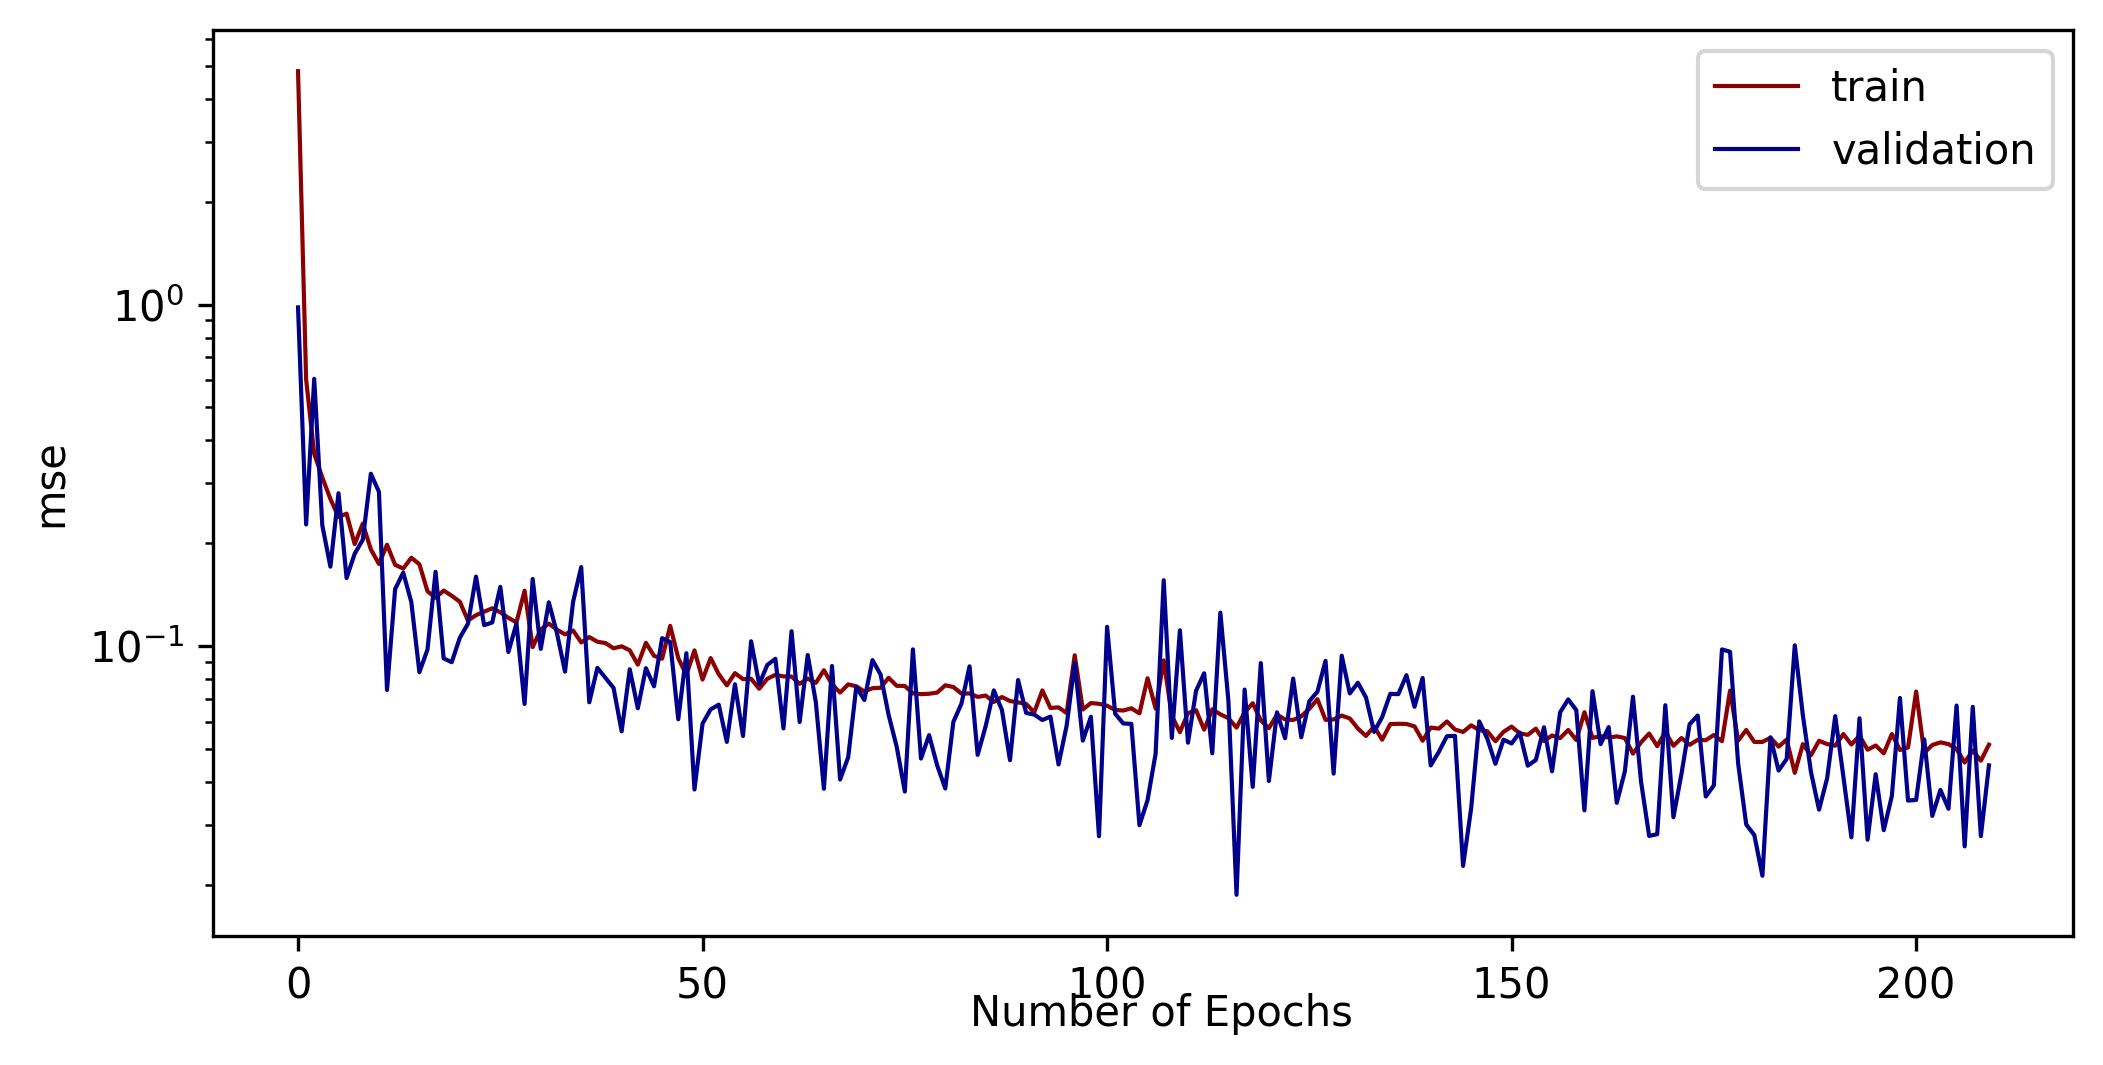

In [69]:
fig, axes = plt.subplots(1, 1, figsize=(8,4), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes.plot(train_values, label='train', color='darkred', linewidth=1)
    axes.plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes.set_ylabel(key)
    if key != 'accuracy':
        axes.set_yscale('log')
axes.legend(loc='upper right')
fig.text(0.52, 0.05, 'Number of Epochs', ha='center')